In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Visualizing the data with attention edges

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 3/12/2021

__Last run:__ 3/12/2021

__Goals:__
We visualize the input graph with the edge transparency controlled by the attention weights

__Before_running:__
Generate the dataset, e.g.
```bash
python n2j/generate_training_labels.py
```

In [34]:
from n2j.trainval_data.graphs.cosmodc2_graph import CosmoDC2Graph
# Features to compile

features = ['ra', 'dec', 'galaxy_id', 'redshift']
features += ['ra_true', 'dec_true', 'redshift_true']
features += ['ellipticity_1_true', 'ellipticity_2_true']
features += ['bulge_to_total_ratio_i', 'ellipticity_1_bulge_true', 'ellipticity_1_disk_true',
             'ellipticity_2_bulge_true', 'ellipticity_2_disk_true', ]
features += ['shear1', 'shear2', 'convergence']
features += ['size_bulge_true', 'size_disk_true', 'size_true']
features += ['mag_{:s}_lsst'.format(b) for b in 'ugrizY']
healpixes = [9559]
raytracing_out_dirs = ['../cosmodc2_raytracing_{:d}'.format(hp) for hp in healpixes]
dataset = CosmoDC2Graph(features=features,
                        raytracing_out_dirs=raytracing_out_dirs,
                        healpixes=healpixes,
                        n_data=[100],
                        aperture_size=1.0,
                        stop_mean_std_early=True)

Which sightlines should we plot? Maybe we want to check out the overdense ones, with high $\kappa$.

In [35]:
for i in range(100):
    if dataset[i].y[0, 0] > 0.05:
        print(i, dataset[i].y)

10 tensor([[0.0558, 0.0086, 0.0172]])
13 tensor([[0.0533, 0.0181, 0.0155]])
47 tensor([[ 0.1559,  0.0271, -0.0535]])
57 tensor([[0.0623, 0.0124, 0.0047]])
67 tensor([[0.0701, 0.0314, 0.0075]])
73 tensor([[0.1327, 0.0054, 0.0184]])
85 tensor([[ 0.0612,  0.0510, -0.0274]])
89 tensor([[ 0.1193, -0.0403, -0.0209]])
94 tensor([[ 0.0571, -0.0244, -0.0319]])


Let's now color the nodes by the redshift.

In [36]:
sightlines = dataset.datasets[0].sightlines

2.0124721729148063


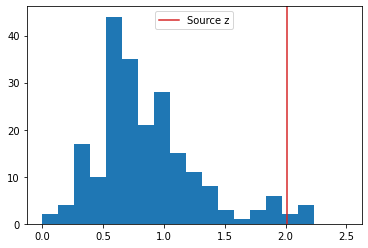

In [38]:
data_i = 0
sample_data = dataset[data_i]
z_src = sightlines.iloc[data_i]['z']
print(z_src)
z = sample_data.x[:, 3].numpy()
z[0] = z_src
plt.hist(z, bins=np.linspace(0, 2.5, 20))
plt.axvline(z_src, color='tab:red', label='Source z')
plt.legend()

We can additionally scale the node size by the (inverse) i-band magnitude.

torch.Size([215, 26]) torch.Size([2, 9651])
tensor([[ 0.0314, -0.0034,  0.0048]])
Error in callback <function flush_figures at 0x7f5c930ae280> (for post_execute):


KeyboardInterrupt: 

In [94]:
summary = np.load('../alpha.npy', allow_pickle=True).item()

attention_edge_index = summary['edge_index']

subgraph_edge_index = sample_data.edge_index.cpu().numpy()
# Find idx of the first edge of the subgraph
first_i, first_j = subgraph_edge_index[:, 0]
print(first_i, first_j)
first_idx = np.where((attention_edge_index[0, :] == first_i) & (attention_edge_index[1, :] == first_j))[0][0]
# Find idx of the last edge of the subgraph
last_i, last_j = subgraph_edge_index[:, -1]
print(last_i, last_j)
last_idx = np.where((attention_edge_index[0, :] == last_i) & (attention_edge_index[1, :] == last_j))[0][0]
print(first_idx, last_idx)

# Slice the attention weights for this subgraph (averaged across the 4 heads)
attention_weights = summary['w'][first_idx:slice_idx+1, :].mean(axis=-1)

13 88
66 94
0 9650


In [97]:
# Add attention weights from node a node b to weights from node b to node a
plot_edge = np.zeros(subgraph_edge_index.shape[1]).astype(bool)
for i in range(subgraph_edge_index.shape[1]):
    a, b = subgraph_edge_index[:, i]
    if a < b:
        plot_edge[i] = True
        find = np.where((attention_edge_index[0, :] == b) & (attention_edge_index[1, :] == a))[0]
        if len(find) == 0:
            continue
        else:
            reverse_i = find[0]
            attention_weights[i] += attention_weights[reverse_i]

(4747, 2)

torch.Size([215, 26]) torch.Size([2, 9651])
tensor([[ 0.0314, -0.0034,  0.0048]])


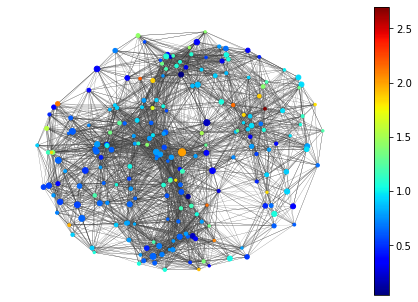

In [107]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib

data_i = 0
cmap = matplotlib.cm.get_cmap('jet')
sample_data = dataset[data_i]
sample_networkx = to_networkx(sample_data)
n_nodes = sample_data.x.shape[0]
# Color by redshift
z = sample_data.x[:, 3].numpy()
z[0] = sightlines.iloc[data_i]['z']
scaled_z = (z - z.min())/(z.max() - z.min())  # scale 0 to 1 for colormap
node_color = cmap(scaled_z)
# Make brighter nodes bigger
mag = -sample_data.x[:, -3].numpy()
mag[0] = np.mean(mag[1:])
node_size = (mag - mag.min())/(mag.max() - mag.min())*30 + 5
node_size[0] = 50
# Control edge transparency with attention weights
edge_color = attention_weights[plot_edge]
edge_color = edge_color/np.sum(edge_color)
edge_cmap = 'greys'

nx.draw(sample_networkx, pos=dict(zip(range(n_nodes), sample_data.x[:, 4:6].tolist())),
        width=0.2,
        # Edge
        edge_color=edge_color, 
        edge_cmap=matplotlib.cm.get_cmap('Greys_r'), 
        edgelist=np.array(sample_networkx.edges())[plot_edge, :],
        arrowsize=1,  
        # Node
        node_color=node_color, node_size=node_size)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
sm.set_array([])
plt.colorbar(sm)

print(sample_data.x.shape, sample_data.edge_index.shape)
print(sample_data.y)

(array([  6.11791315,   0.        ,   9.53256114, 105.28500361,
         45.92704939,  47.46361784,  17.55698574,  16.19112623,
         11.32525753,   5.71953376,   5.26425287,   1.22358185,
          1.13821684,   0.540653  ,   0.51219705,   0.34146505,
          0.11382168,   0.        ,   0.        ,   0.36992047]),
 array([0.00434202, 0.00798337, 0.01162473, 0.01526608, 0.01890743,
        0.02254879, 0.02619014, 0.02983149, 0.03347285, 0.0371142 ,
        0.04075556, 0.04439691, 0.04803826, 0.05167961, 0.05532097,
        0.05896232, 0.06260367, 0.06624503, 0.06988639, 0.07352774,
        0.07716909], dtype=float32),
 <BarContainer object of 20 artists>)

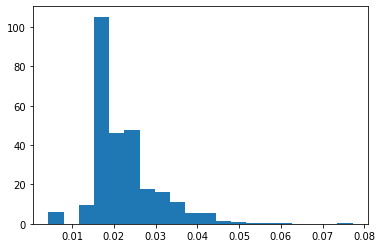

In [85]:
_ = plt.hist(attention_weights, density=True, bins=20)

(array([  360.84348214,     0.        ,  1586.46686309, 10887.52002737,
         4902.49473232,  5711.27947985,  1717.11818227,  1586.46652218,
         1312.72440746,   373.28624051,   591.03654748,   205.30760875,
           37.32862405,    31.10721345,    74.65718393,    74.65731227,
           24.88577076,     0.        ,     0.        ,    55.9929842 ]),
 array([4.32932902e-05, 7.71535197e-05, 1.11013745e-04, 1.44873979e-04,
        1.78734204e-04, 2.12594430e-04, 2.46454671e-04, 2.80314882e-04,
        3.14175122e-04, 3.48035333e-04, 3.81895574e-04, 4.15755814e-04,
        4.49616025e-04, 4.83476266e-04, 5.17336477e-04, 5.51196747e-04,
        5.85056958e-04, 6.18917169e-04, 6.52777380e-04, 6.86637650e-04,
        7.20497861e-04], dtype=float32),
 <BarContainer object of 20 artists>)

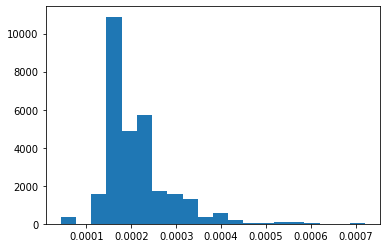

In [109]:
_ = plt.hist(edge_color, density=True, bins=20)

In [118]:
edge_mean = np.median(edge_color)
edge_cmap = matplotlib.cm.get_cmap('Greys_r')
color_mean = edge_cmap(edge_mean)

torch.Size([215, 26]) torch.Size([2, 9651])
tensor([[ 0.0314, -0.0034,  0.0048]])


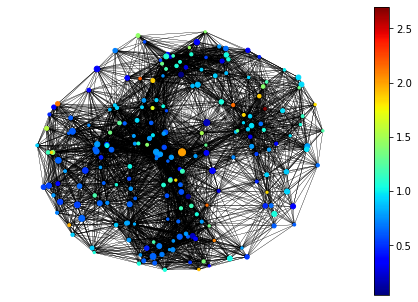

In [119]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib

data_i = 0
cmap = matplotlib.cm.get_cmap('jet')
sample_data = dataset[data_i]
sample_networkx = to_networkx(sample_data)
n_nodes = sample_data.x.shape[0]
# Color by redshift
z = sample_data.x[:, 3].numpy()
z[0] = sightlines.iloc[data_i]['z']
scaled_z = (z - z.min())/(z.max() - z.min())  # scale 0 to 1 for colormap
node_color = cmap(scaled_z)
# Make brighter nodes bigger
mag = -sample_data.x[:, -3].numpy()
mag[0] = np.mean(mag[1:])
node_size = (mag - mag.min())/(mag.max() - mag.min())*30 + 5
node_size[0] = 50

nx.draw(sample_networkx, pos=dict(zip(range(n_nodes), sample_data.x[:, 4:6].tolist())),
        width=0.2, 
        edge_color=color_mean, arrowsize=1,
        node_color=node_color, node_size=node_size)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
sm.set_array([])
plt.colorbar(sm)

print(sample_data.x.shape, sample_data.edge_index.shape)
print(sample_data.y)